<a href="https://colab.research.google.com/github/vinbaskaran/AI_projects/blob/main/Demo_3_2_%7C_Generative_Search_with_OpenAI_and_Chroma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. <font color = red> Install and Import the Required Libraries

In [ ]:
# Install all the required libraries

!pip install -U -q pdfplumber tiktoken openai chromaDB sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 692.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## 2. <font color = red> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [ ]:
# Define the path of the PDF
single_pdf_path = '/content/drive/MyDrive/GenAI - Personal/HelpMate AI Codes/Week 3/Policy Documents/HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf'
# single_pdf_path = "/content/drive/My Drive/HelpMate AI Codes/Policy Documents/HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf"

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber

In [ ]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[6]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

In [ ]:
# View the table in the page, if any

tables[0]

[['',
  '',
  'apart; and\nii. Requiring continuous permanent supplementary oxygen therapy for hypoxemia;\nand\niii. Arterial blood gas analysis with partial oxygen pressure of 55mmHg or less\n(PaO2 < 55mmHg); and\niv. Dyspnea at rest.'],
 ['11',
  'Loss of\nIndepende\nnt\nExistence',
  'Confirmation by a consultant physician acceptable to the Company of the loss of\nindependent existence due to Illness or trauma, which has lasted for a minimum\nperiod of 6 months and results in a permanent inability to perform at least three (3) of\nthe Activities of Daily Living (either with or without the use of mechanical\nequipment, special devices or other aids and adaptations in use for disabled persons).\nFor the purpose of this benefit, the word “permanent”, shall mean beyond the hope of\nrecovery with current medical knowledge and technology.\nActivities of Daily Living are:-\na) Washing: the ability to wash in the bath or shower (including getting into and out\nof the bath or shower) or wash

#### <font color = red> 2.2 Extracting text from multiple PDFs

Let's now try and read multiple documents, extract text from them using appropriate preprocessing, and store them in a dataframe


In [ ]:
# Define the path where all pdf documents are present

# pdf_path = "/content/drive/My Drive/HelpMate AI Codes/Policy Documents"
pdf_path = "/content/drive/MyDrive/GenAI - Personal/HelpMate AI Codes/Week 3/Policy Documents"

In [ ]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [ ]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [ ]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing HDFC-Life-Smart-Pension-Plan-Policy-Document-Online.pdf
Finished processing HDFC-Life-Smart-Pension-Plan-Policy-Document-Online.pdf
...Processing HDFC-Surgicare-Plan-101N043V01.pdf
Finished processing HDFC-Surgicare-Plan-101N043V01.pdf
...Processing HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf
Finished processing HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf
...Processing HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf
Finished processing HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf
...Processing HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf
Finished processing HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf
...Processing HDFC-Life-Group-Term-Life-Policy.pdf
Finished processing HDFC-Life-Group-Term-Life-Policy.pdf
...Processing HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf
Finished processing HDFC-Life-Easy-Health-101N110V03-Policy-

In [ ]:
# Concatenate all the DFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [ ]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name
0,Page 1,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...
1,Page 2,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...
2,Page 3,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...
3,Page 4,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...
4,Page 5,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...
...,...,...,...
212,Page 29,Annexure II Section 39 - Nomination by Policyh...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...
213,Page 30,Disclaimer: This is not a comprehensive list o...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...
214,Page 31,Annexure III Provisions regarding Policy not b...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...
215,Page 32,Annexure IV Section 38 - Assignment or Transfe...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...


In [ ]:
# Check one of the extracted page texts to ensure that the text has been correctly read

insurance_pdfs_data.Page_Text[2]

'HDFC Life Smart Pension Plan 101L164V02 – Terms and Conditions (Direct & Online Sales) A Unit Linked Non-Participating Individual Pension Plan [["Name of Appointee, if Nominee is\\nminor", ""], ["Special Conditions", "\\u00abZENDFLD_001\\u00bb\\n\\u00abZENDFLD_002\\u00bb\\n\\u00abZENDFLD_003\\u00bb\\n\\u00abZENDFLD_004\\u00bb\\n\\u00abZENDFLD_005\\u00bb"]] Stamp Duty of Rs. /- is paid as provided under Article 47D(iii) of Indian Stamp Act, 1899 and included in Consolidated Stamp Duty Paid to the Government of Maharashtra Treasury vide Order of Addl. Controller Of Stamps, Mumbai at General Stamp Office, Fort, Mumbai - 400001., vide this Order No.(LOA/CSD/150/2021/Validity Period Dt.07/10/2021 To Dt.31/03/2022 (O/w.No.4088)/Date : 07/10/2021). «Legend_schedule»«ADDAMT» Page 3 of 37'

In [ ]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [ ]:
insurance_pdfs_data['Text_Length']

0      365
1      266
2       93
3      526
4      588
      ... 
212    766
213     43
214    674
215    728
216     43
Name: Text_Length, Length: 217, dtype: int64

In [ ]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,365
1,Page 2,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,266
2,Page 3,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,93
3,Page 4,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,526
4,Page 5,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,588
...,...,...,...,...
212,Page 29,Annexure II Section 39 - Nomination by Policyh...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,766
213,Page 30,Disclaimer: This is not a comprehensive list o...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,43
214,Page 31,Annexure III Provisions regarding Policy not b...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,674
215,Page 32,Annexure IV Section 38 - Assignment or Transfe...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,728


In [ ]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

<ipython-input-17-4493f15e2dc4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)


In [ ]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,365,{'Policy_Name': 'HDFC-Life-Smart-Pension-Plan-...
1,Page 2,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,266,{'Policy_Name': 'HDFC-Life-Smart-Pension-Plan-...
2,Page 3,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,93,{'Policy_Name': 'HDFC-Life-Smart-Pension-Plan-...
3,Page 4,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,526,{'Policy_Name': 'HDFC-Life-Smart-Pension-Plan-...
4,Page 5,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,588,{'Policy_Name': 'HDFC-Life-Smart-Pension-Plan-...
...,...,...,...,...,...
212,Page 29,Annexure II Section 39 - Nomination by Policyh...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,766,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...
213,Page 30,Disclaimer: This is not a comprehensive list o...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,43,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...
214,Page 31,Annexure III Provisions regarding Policy not b...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,674,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...
215,Page 32,Annexure IV Section 38 - Assignment or Transfe...,HDFC-Life-Easy-Health-101N110V03-Policy-Bond-S...,728,{'Policy_Name': 'HDFC-Life-Easy-Health-101N110...


This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [ ]:
# Set the API key
filepath = "/content/drive/MyDrive/GenAI - Personal/HelpMate AI Codes/"

with open(filepath + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [ ]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [ ]:
# Define the path where chroma collections will be stored

chroma_data_path = '/content/drive/MyDrive/GenAI - Personal/HelpMate AI Codes/Week 3/ChromaDB_Data'

In [ ]:
import chromadb

In [ ]:
# Call PersistentClient()

client = chromadb.PersistentClient()

In [ ]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [ ]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embedding_function)

In [ ]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [ ]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [ ]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[-0.0045278058387339115,
   0.0054623824544250965,
   0.014899247325956821,
   -0.043024275451898575,
   -0.02039199508726597,
   0.02207895740866661,
   0.007894981652498245,
   0.004679632373154163,
   -0.02503451332449913,
   -0.005131737794727087,
   0.013914061710238457,
   0.03965035080909729,
   -0.021809043362736702,
   0.008441557176411152,
   -0.0027227564714848995,
   0.016829131171107292,
   0.0161813385784626,
   -0.019190877676010132,
   0.03436003997921944,
   -0.010978748090565205,
   0.015196152962744236,
   0.014966725371778011,
   -0.003220410319045186,
   0.009548204019665718,
   -0.006859187036752701,
   -0.02804405428469181,
   0.019825175404548645,
   0.0026434692554175854,
   -0.007355153560638428,
   -0.00023195725225377828,
   0.0019130147993564606,
   0.009082602337002754,
   -0.0216875821352005,
   -0.01094500906765461,
   -0.0011226731585338712,
   0.011316140182316303,
   -0.004713371396064758,
   -0.022780733183026

In [ ]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [ ]:
cache_collection.peek()

{'ids': [],
 'embeddings': [],
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None}

## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [ ]:
# Read the user query

query = input()

what are the death benefits


In [ ]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [ ]:
cache_results

{'ids': [[]],
 'distances': [[]],
 'metadatas': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None}

In [ ]:
results = insurance_collection.query(
query_texts=query,
n_results=10
)
# results.items()

In [ ]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        for i in range(10):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Not found in cache. Found in main collection.


In [ ]:
results_df

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 6', 'Policy_Name': 'HDFC-Li...",PART C Product Core Benefits BENEFITS PAYABLE ...,0.315611,88
1,"{'Page_No.': 'Page 15', 'Policy_Name': 'HDFC-L...","Note: For the purpose of waiting period, Date ...",0.359042,66
2,"{'Page_No.': 'Page 8', 'Policy_Name': 'HDFC-Li...",HDFC Life Smart Pension Plan 101L164V02 – Term...,0.360684,7
3,"{'Page_No.': 'Page 8', 'Policy_Name': 'HDFC-Li...","[[""21. Progressive\nScleroderma"", ""22. Muscula...",0.361761,59
4,"{'Page_No.': 'Page 11', 'Policy_Name': 'HDFC-L...",PART C PRODUCT CORE BENEFITS BENEFITS PAYABLE ...,0.368395,158
5,"{'Page_No.': 'Page 7', 'Policy_Name': 'HDFC-Li...",Part C 1. Benefits: (1) Benefits on Death or d...,0.380276,58
6,"{'Page_No.': 'Page 23', 'Policy_Name': 'HDFC-L...",HDFC Life Smart Pension Plan 101L164V02 – Term...,0.388185,22
7,"{'Page_No.': 'Page 13', 'Policy_Name': 'HDFC-L...",HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,0.389877,133
8,"{'Page_No.': 'Page 19', 'Policy_Name': 'HDFC-L...","(i) Death Certificate, in original, issued by ...",0.398594,101
9,"{'Page_No.': 'Page 8', 'Policy_Name': 'HDFC-Li...",HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,0.409864,128


## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

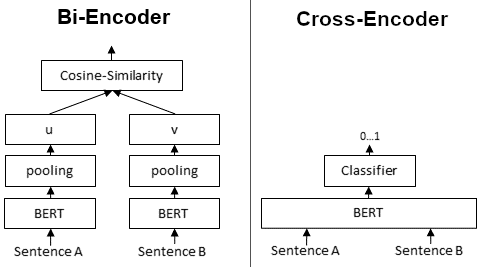

<br>

In [ ]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [ ]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [ ]:
scores

array([  3.84676 , -11.252879], dtype=float32)

In [ ]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [ ]:
cross_rerank_scores

array([ 3.249364 ,  2.1121206,  1.3146138, -1.7923446, -0.3002559,
        2.7251635, -0.7524963, -2.0720592, -1.7593772,  1.0998156],
      dtype=float32)

In [ ]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [ ]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 6', 'Policy_Name': 'HDFC-Li...",PART C Product Core Benefits BENEFITS PAYABLE ...,0.315611,88,3.249364
1,"{'Page_No.': 'Page 15', 'Policy_Name': 'HDFC-L...","Note: For the purpose of waiting period, Date ...",0.359042,66,2.112121
2,"{'Page_No.': 'Page 8', 'Policy_Name': 'HDFC-Li...",HDFC Life Smart Pension Plan 101L164V02 – Term...,0.360684,7,1.314614
3,"{'Page_No.': 'Page 8', 'Policy_Name': 'HDFC-Li...","[[""21. Progressive\nScleroderma"", ""22. Muscula...",0.361761,59,-1.792345
4,"{'Page_No.': 'Page 11', 'Policy_Name': 'HDFC-L...",PART C PRODUCT CORE BENEFITS BENEFITS PAYABLE ...,0.368395,158,-0.300256
5,"{'Page_No.': 'Page 7', 'Policy_Name': 'HDFC-Li...",Part C 1. Benefits: (1) Benefits on Death or d...,0.380276,58,2.725163
6,"{'Page_No.': 'Page 23', 'Policy_Name': 'HDFC-L...",HDFC Life Smart Pension Plan 101L164V02 – Term...,0.388185,22,-0.752496
7,"{'Page_No.': 'Page 13', 'Policy_Name': 'HDFC-L...",HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,0.389877,133,-2.072059
8,"{'Page_No.': 'Page 19', 'Policy_Name': 'HDFC-L...","(i) Death Certificate, in original, issued by ...",0.398594,101,-1.759377
9,"{'Page_No.': 'Page 8', 'Policy_Name': 'HDFC-Li...",HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,0.409864,128,1.099816


In [ ]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 6', 'Policy_Name': 'HDFC-Li...",PART C Product Core Benefits BENEFITS PAYABLE ...,0.315611,88,3.249364
1,"{'Page_No.': 'Page 15', 'Policy_Name': 'HDFC-L...","Note: For the purpose of waiting period, Date ...",0.359042,66,2.112121
2,"{'Page_No.': 'Page 8', 'Policy_Name': 'HDFC-Li...",HDFC Life Smart Pension Plan 101L164V02 – Term...,0.360684,7,1.314614


In [ ]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 6', 'Policy_Name': 'HDFC-Li...",PART C Product Core Benefits BENEFITS PAYABLE ...,0.315611,88,3.249364
5,"{'Page_No.': 'Page 7', 'Policy_Name': 'HDFC-Li...",Part C 1. Benefits: (1) Benefits on Death or d...,0.380276,58,2.725163
1,"{'Page_No.': 'Page 15', 'Policy_Name': 'HDFC-L...","Note: For the purpose of waiting period, Date ...",0.359042,66,2.112121


In [ ]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [ ]:
top_3_RAG

,Documents,Metadatas
0,PART C Product Core Benefits BENEFITS PAYABLE ...,"{'Page_No.': 'Page 6', 'Policy_Name': 'HDFC-Li..."
5,Part C 1. Benefits: (1) Benefits on Death or d...,"{'Page_No.': 'Page 7', 'Policy_Name': 'HDFC-Li..."
1,"Note: For the purpose of waiting period, Date ...","{'Page_No.': 'Page 15', 'Policy_Name': 'HDFC-L..."


## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [ ]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [ ]:
# Generate the response

response = generate_response(query, top_3_RAG)

In [ ]:
# Print the response

print("\n".join(response))

The death benefits in insurance policies refer to the amount of money that is paid out to the designated beneficiaries in the event of the policyholder's death. These benefits are intended to provide financial support to the policyholder's loved ones and help cover expenses such as funeral costs, outstanding debts, and ongoing living expenses.

In the insurance document titled "HDFC-Life Insurance Policy", on page 6, under "PART C Product Core Benefits - BENEFITS PAYABLE ON DEATH", you can find detailed information about the death benefits offered by the policy. The full policy name is "HDFC-Life Insurance Policy" and the relevant page number is 6.

Additionally, in the same document, on page 7, under "Part C 1. Benefits: (1) Benefits on Death or diagnosis of Terminal Illness:", you can find further information about the death benefits provided by the policy. The relevant page number is 7.

The aim of the death benefits is to provide financial security to the policyholder's beneficiari